In [1]:
from functools import reduce

import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

%matplotlib inline

In [8]:
train_data = pd.read_csv('../data/train.csv')

In [59]:
test_data = pd.read_csv('../data/test.csv')

In [60]:
test_data = test_data.fillna('')

In [23]:
train_data[train_data.question2.isnull() == True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [9]:
train_data = train_data.fillna('')

In [4]:
val_data = train_data.iloc[int(len(train_data)*0.9):]
train_data = train_data.iloc[:int(len(train_data)*0.9)]

In [3]:
len(train_data)

404290

In [4]:
train_data = train_data.dropna()

In [25]:
len(train_data)

404290

In [10]:
q1 = list(train_data['question1'].apply(str.lower))
q2 = list(train_data['question2'].apply(str.lower))
y = list(train_data['is_duplicate'])

q1_val = list(val_data['question1'].apply(str.lower))
q2_val = list(val_data['question2'].apply(str.lower))
y_val = list(val_data['is_duplicate'])

In [61]:
q1_test = list(test_data['question1'].apply(str.lower))
q2_test = list(test_data['question2'].apply(str.lower))

In [28]:
1 - sum(y) / len(y)

0.63080214697370707

In [11]:
q1_token = [word_tokenize(x) for x in q1]
q2_token = [word_tokenize(x) for x in q2]
q1_token_val = [word_tokenize(x) for x in q1_val]
q2_token_val = [word_tokenize(x) for x in q2_val]

In [39]:
q1_token = [x.split() for x in q1]
q2_token = [x.split() for x in q2]

q1_token_val = [x.split() for x in q1_val]
q2_token_val = [x.split() for x in q2_val]

In [63]:
q1_token_test = [x.split() for x in q1_test]
q2_token_test = [x.split() for x in q2_test]

In [12]:
stop_words = stopwords.words('english')

In [32]:
def word_match_share(x, stops):
    q1words = {}
    q2words = {}
    for word in x[0]:
        if word not in stops:
            q1words[word] = 1
    for word in x[1]:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [68]:
def jaccard(x):
    wic = set(x[0]).intersection(set(x[1]))
    uw = set(x[0]).union(set(x[1]))
    for w in stop_words:
        wic.discard(w)
        uw.discard(w)
    if len(uw) == 0:
        uw = [1]
    return (len(wic) / len(uw))

In [41]:
X = zip(q1_token, q2_token)
X_val = zip(q1_token_val, q2_token_val)

In [69]:
X_test = zip(q1_token_test, q2_token_test)
word_match_test = list(map(lambda p: jaccard(p), X_test))

In [15]:
word_match = list(map(lambda p: word_match_share(p, stop_words), X))
word_match_val = list(map(lambda p: word_match_share(p, stop_words), X_val))

NameError: name 'word_match_share' is not defined

In [42]:
word_match = list(map(lambda p: jaccard(p), X))
word_match_val = list(map(lambda p: jaccard(p), X_val))

In [43]:
data = {'sim': word_match, 'dup':y}
data = pd.DataFrame.from_dict(data)

In [44]:
data_val = {'sim': word_match_val, 'dup':y_val}
data_val = pd.DataFrame.from_dict(data_val)

In [70]:
data_test = {'sim': word_match_test}
data_test = pd.DataFrame.from_dict(data_test)

In [45]:
data['bucket'] = data['sim'].map(lambda x: x // 0.05 * 0.05)

In [46]:
data_val['bucket'] = data_val['sim'].map(lambda x: x // 0.05 * 0.05)

In [71]:
data_test['bucket'] = data_test['sim'].map(lambda x: x // 0.05 * 0.05)

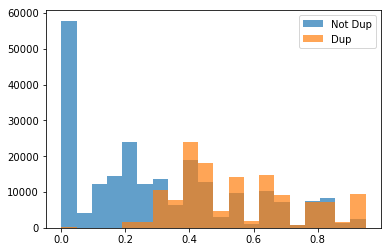

In [150]:
plt.hist(data[data['dup'] == 0]['bucket'], bins=20, label='Not Dup', alpha=0.7)
plt.hist(data[data['dup'] == 1]['bucket'], bins=20, label='Dup', alpha=0.7)
plt.legend()

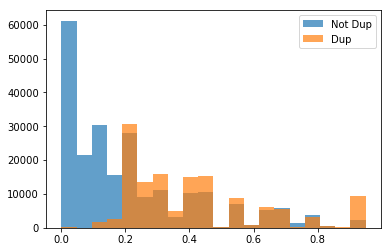

In [184]:
plt.hist(data[data['dup'] == 0]['bucket'], bins=20, label='Not Dup', alpha=0.7)
plt.hist(data[data['dup'] == 1]['bucket'], bins=20, label='Dup', alpha=0.7)
plt.legend()

In [47]:
counts = data.groupby(['bucket','dup'])['sim'].count()

In [48]:
bucket_weights = counts.div(data.groupby(['bucket'])['dup'].count(), axis='index',level=0)

In [31]:
bucket_weights.loc[(0.05, 1)] = 0.00

In [27]:
bucket_weights.loc[(0.00, 1)] = 0.00

In [50]:
data_val['pred'] = data_val['bucket'].map(lambda x: bucket_weights.loc[(x, 1)])

data_val['pred'] = data_val['pred'].map(lambda x: max(0.01, min(x, 0.99)))

data_val['pred_int'] = data_val['pred'].map(lambda x: int(x >= 0.5))

In [72]:
data_test['pred'] = data_test['bucket'].map(lambda x: bucket_weights.loc[(x, 1)])

data_test['pred'] = data_test['pred'].map(lambda x: max(0.01, min(x, 0.99)))

data_test['pred_int'] = data_test['pred'].map(lambda x: int(x >= 0.5))

In [84]:
log_loss([0, 1, 0], [0.5, 0.5, 0.5])

0.69314718055994529

In [92]:
sub = data_test.reset_index()[['index','pred']]
sub.columns = ['test_id','is_duplicate']

In [95]:
sub = sub.set_index('test_id')

In [96]:
sub.to_csv('submission1.csv')

In [74]:
test_data

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [53]:
log_loss(data_val['dup'], data_val['pred'])

0.46282164138586046

In [54]:
dv_tight = data_val[abs(data_val['pred'] - 0.5) > 0.2]

In [55]:
len(dv_tight) / len(data_val)

0.4143807662816295

In [57]:
log_loss(dv_tight['dup'], dv_tight['pred'])

0.14480828420989858

In [58]:
accuracy_score(dv_tight['dup'], dv_tight['pred_int'])

0.9535605563182713

In [230]:
dv_tight[dv_tight['pred_int'] != dv_tight['dup']]

,dup,sim,bucket,pred,pred_int
65,0,1.000000,0.95,0.800288,1
74,1,0.166667,0.15,0.135825,0
140,1,0.111111,0.10,0.049696,0
171,1,0.181818,0.15,0.135825,0
220,1,0.125000,0.10,0.049696,0
275,1,0.181818,0.15,0.135825,0
516,1,0.166667,0.15,0.135825,0
517,0,1.000000,0.95,0.800288,1
645,1,0.181818,0.15,0.135825,0
764,1,0.166667,0.15,0.135825,0


In [192]:
accuracy_score(data_val['dup'], data_val['pred_int'])

0.71428924781716097

In [41]:
for thresh in np.arange(0.2, 1.0, 0.1):
    col = 'pred_{}'.format(thresh)
    data[col] = (data['sim'] > thresh).map(int)
    print(thresh, 
          log_loss(data['dup'], data[col]), 
          accuracy_score(data['dup'], data[col]),
          roc_auc_score(data['dup'], data[col]))

0.2 18.1912693705 0.473320998892 0.5825227892
0.3 15.9613799507 0.537881411271 0.633590624381
0.4 12.9169660958 0.626024022479 0.699637413354
0.5 11.4673844558 0.667991629729 0.706014815835
0.6 11.2833961901 0.673317041317 0.674548814929
0.7 11.608246575 0.663910380719 0.630790111937
0.8 12.2169720621 0.646284331961 0.567114750166
0.9 11.8363292727 0.65730370429 0.54891815911


In [236]:
tf = TfidfVectorizer()

In [237]:
corpus = list(train_data['question1']) + list(train_data['question2'])

In [238]:
tf.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [239]:
tfidfs_q1 = tf.transform(list(train_data['question1']))
train_tfidf_q1 = tfidfs_q1[:len(train_data)]
tfidfs_q2 = tf.transform(list(train_data['question2']))
train_tfidf_q2 = tfidfs_q2[:len(train_data)]

In [10]:
tf_q1_dense = tfidfs_q1.todense()

tf_q2_dense = tfidfs_q2.todense()

In [20]:
def word_match_share_tfidf(ind):
    if ind % 1000 == 0:
        print(ind)
    q1 = tfidfs_q1[ind].nonzero()[1]
    q2 = tfidfs_q2[ind].nonzero()[1]
    total_weight = 0
    shared_weight = 0
    for w in q1:
        total_weight += tfidfs_q1[ind, w]
        if w in q2:
            shared_weight += tfidfs_q1[ind, w]
    for w in q2:
        total_weight += tfidfs_q2[ind, w]
        if w in q1:
            shared_weight += tfidfs_q2[ind, w]
    return shared_weight / total_weight

In [21]:
word_match_tfidf = list(map(lambda x: word_match_share_tfidf(x), range(len(train_data))))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [26]:
word_match_tfidf

[0.9677301609533917,
 0.65384854017658089,
 0.30311200642362957,
 0.0,
 0.33577414226089841,
 0.59848924988136909,
 0.0,
 0.54950454546282901,
 0.94690886963458909,
 0.52321776629296879,
 0.046245274110902616,
 0.57046138109306921,
 0.88850696838316701,
 0.93490441114554312,
 0.9421521380532295,
 0.24314442600193703,
 0.71286912676704939,
 0.054358138525965799,
 0.39343756415601605,
 0.61566870932313411,
 0.55070329782831451,
 0.51310427080640553,
 0.58196016441474641,
 0.0,
 0.14805297366006703,
 0.81663948683194121,
 0.79681450717978097,
 0.3863019551185351,
 0.78433306838048999,
 0.58838337184914169,
 0.63381692877239082,
 0.38438026421309235,
 0.8462267888286148,
 0.027370625459602525,
 0.82082980076504863,
 0.38514486974598211,
 0.553257390446663,
 0.27326062748413249,
 0.51884424336735779,
 0.24133687693278444,
 0.0,
 0.96056089858085603,
 0.8435082707653252,
 0.48447622990538114,
 0.85429649315829304,
 0.45768085088151189,
 0.0,
 0.098183546369047719,
 0.7331042183516564,
 0.841

In [42]:
data = {'sim': word_match_tfidf, 'dup':y}
data = pd.DataFrame.from_dict(data)

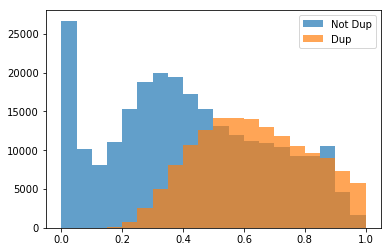

In [43]:
plt.hist(data[data['dup'] == 0]['sim'], bins=20, label='Not Dup', alpha=0.7)
plt.hist(data[data['dup'] == 1]['sim'], bins=20, label='Dup', alpha=0.7)
plt.legend()

In [50]:
for thresh in np.arange(0.2, 1.0, 0.1):
    col = 'pred_{}'.format(thresh)
    data[col] = (data['sim'] > thresh).map(int)
    print(thresh, 
          log_loss(data['dup'], data[col]), 
          accuracy_score(data['dup'], data[col]),
          roc_auc_score(data['dup'], data[col]))

0.2 17.0188706694 0.507264623239 0.609211279391
0.3 14.3923944499 0.583306949501 0.664911127083
0.4 12.1368494095 0.648609407155 0.698521433464
0.5 11.3489392256 0.671419878898 0.68417808862
0.6 11.6231233754 0.663479994459 0.638485490212
0.7 12.0326363655 0.65162211097 0.591664145347
0.8 12.2683018693 0.644797767928 0.555060388461
0.9 12.1618155244 0.647879729302 0.53172112566
